# Generalization of Two Layers

## Init

In [1]:
#Autocomplete
%config Completer.use_jedi = False

In [2]:
%matplotlib inline
%time

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

Wall time: 0 ns


In [3]:
os.environ['KERAS_BACKEND'] = "tensorflow"

import keras
import keras.backend as K
from keras import models, layers
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.initializers import glorot_normal, RandomNormal
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [5]:
# adding project's file
import metric as M
from visualization import visualize

## Simple Data

In [6]:
relu = lambda A: np.maximum(A, 0)
drelu = lambda A: (A > 0).astype(np.float)
sgn = lambda A: (A > 0).astype(np.float)*2 - 1
sgn01 = lambda A: (A > 0).astype(np.float)

In [7]:
# params
m = 300 # Sample size
d = 15 # Input size
np.random.seed(6) # fix random seed for reproducibility
X = np.random.randint(low=0, high=2, size=(d,m)) * 2 - 1 # sample set in {-1,+1}^d
w_single_neuron = np.random.randn(d) / np.sqrt(d)
W_multiple_neurons = np.random.randn(d, d) / np.sqrt(d)
u_multiple_neurons = np.random.randn(d, 1) / np.sqrt(d)
Y_single_neuron = (np.sign(X.T @ w_single_neuron) + 1) // 2
Y_multiple_neurons = np.squeeze(sgn01(u_multiple_neurons.T @ relu(W_multiple_neurons @ X)))

In [8]:
# Train and Test sets
perm = np.random.permutation(m)
X_train = X[:, perm[:m//2]].transpose()
X_test = X[:, perm[m//2:]].transpose()
Y_single_train = Y_single_neuron[perm[:m//2]]
Y_single_test = Y_single_neuron[perm[m//2:]]
Y_mult_train = Y_multiple_neurons[perm[:m//2]]
Y_mult_test = Y_multiple_neurons[perm[m//2:]]

## Two-Layers Network

In [9]:
def get_generalization(history, metric='loss'):
    return np.array(history.history['val_' + metric]) - np.array(history.history[metric])

In [30]:
class SimpleNN(Model):
    def __init__(self, input_dim,
                 hidden_layers=None,
                 dist_from_init=None,
                 learning_rate=0.1,
                 metrics=['accuracy'],
                 seed=0):
        super(SimpleNN, self).__init__()
        
        self.distance_from_init = dist_from_init
        if dist_from_init is not None:
            self.distance_from_init = tf.constant(dist_from_init, dtype=tf.float32)
        
        if hidden_layers is None:
            hidden_layers = input_dim
            
        self.seq = Sequential()
        self.d1 = Dense(hidden_layers, input_dim=input_dim, activation='relu', use_bias=False,
                        kernel_initializer=RandomNormal(mean=0.0, stddev=1./np.sqrt(input_dim), seed=seed))
        self.d2 = Dense(1, activation='sigmoid', use_bias=False,
                        kernel_initializer=RandomNormal(mean=0.0, stddev=1./np.sqrt(hidden_layers), seed=seed+1))
        
        self.learning_rate = learning_rate
        self.init_weights = None
        self.gradients = None
        self.norms = []
        self.compile(loss='binary_crossentropy', metrics=metrics, run_eagerly=True,
                     optimizer=keras.optimizers.SGD(lr=self.learning_rate))

        
    def call(self, x):
        x = self.seq(x)
        x = self.d1(x)
        return self.d2(x)
    
    
    def train_step(self, data):
        # Unpack the data
        X, y = data
        
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            predictions = self(X, training=True)  # Forward pass
            # Compute the loss value
            loss = self.compiled_loss(y, predictions)
            
        # Saves the initial weights
        if self.init_weights is None:
            self.init_weights = []
            for wgt in self.trainable_variables:
                wgt_0 = tf.Variable(wgt, trainable=False)
                wgt_0.assign(wgt)
                self.init_weights.append(wgt_0)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        norm_by_layer = [(x.numpy()**2).sum() for x in gradients]
        self.norms.append(norm_by_layer)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Normalize weights in needed
        if self.distance_from_init is not None:
            for wgt_t, wgt_0 in zip(self.trainable_variables, self.init_weights):
                diff = wgt_t - wgt_0
                d = tf.norm(diff, ord='fro', axis=(0,1))
                ratio = tf.minimum(tf.divide(self.distance_from_init, d), tf.constant(1.0))
                wgt_t.assign(tf.math.scalar_mul(ratio, diff) + wgt_0)

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, predictions)
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
            
    
    def get_norms (self, layer=None, num_batches=1):
        norm_list = []
        for i in range(0, len(self.norms), num_batches):
            nrm = np.array(self.norms[i])
            for j in range(i+1, i+num_batches):
                nrm += np.array(self.norms[j])
            norm_list.append(nrm / num_batches)
            
        if layer is None:
            return [np.sqrt(sum(x)) for x in norm_list]
        else:
            return [np.sqrt(x[layer]) for x in norm_list]

## Evaluation

### Verification

(<Figure size 1080x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>], dtype=object))

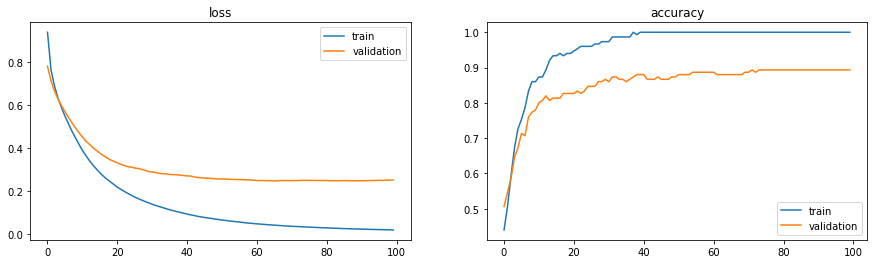

In [39]:
num_epochs = 100
model_sing = SimpleNN(d, learning_rate=0.1)
history = model_sing.fit(x=X_train, y=Y_single_train, validation_data=(X_test,Y_single_test),
                            batch_size=20, verbose=0, epochs=num_epochs)

visualize(history)

(<Figure size 1080x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>], dtype=object))

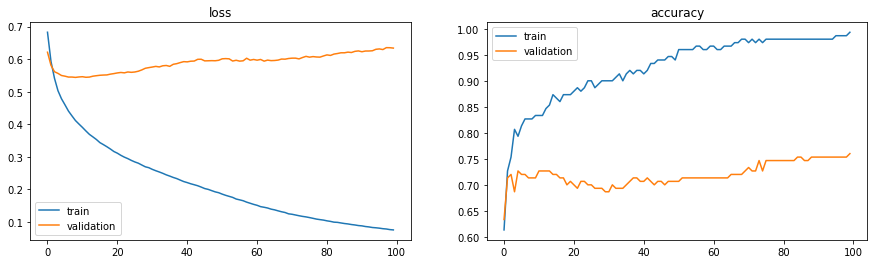

In [35]:
num_epochs = 100
model_mult = SimpleNN(d, learning_rate=0.1)
history = model_mult.fit(x=X_train, y=Y_mult_train, validation_data=(X_test,Y_mult_test),
                            batch_size=20, verbose=0, epochs=num_epochs)

visualize(history)

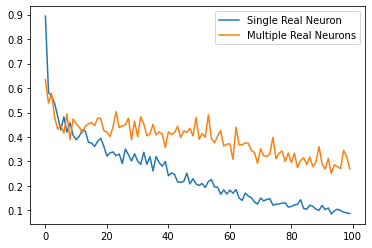

In [40]:
plt.plot(model_sing.get_norms(num_batches = 8), label='Single Real Neuron')
plt.plot(model_mult.get_norms(num_batches = 8), label='Multiple Real Neurons')
plt.legend()
plt.show()

### Change Width

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 1080x360 with 0 Axes>

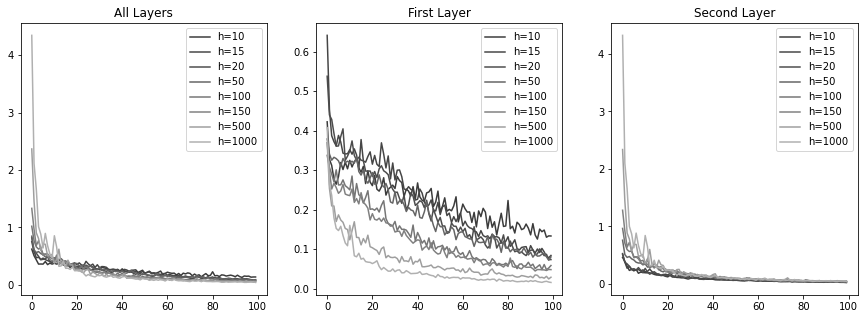

In [51]:
hidden_range = [10, 15, 20, 50, 100, 150, 500, 1000]
num_epochs = 100

plt.figure(figsize=(15,5))
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

for h in tqdm(hidden_range):
    model = SimpleNN(d, hidden_layers=h, learning_rate=0.1)
    history = model.fit(x = X_train, y = Y_single_train, validation_data=(X_test,Y_single_test),
                        batch_size=20, verbose=0, epochs=num_epochs)

    ax1.plot(model.get_norms(num_batches=8), label='h=%d'%h, color='%g'%(np.log(h)/10))
    ax2.plot(model.get_norms(layer=0, num_batches=8), label='h=%d'%h, color='%g'%(np.log(h)/10))
    ax3.plot(model.get_norms(layer=1, num_batches=8), label='h=%d'%h, color='%g'%(np.log(h)/10))

    
ax1.set_title("All Layers")
ax2.set_title("First Layer")
ax3.set_title("Second Layer")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()